In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pandas as pd

class World:
    def __init__(self):
        self.height = height
        self.width = width
        self.obstacles = obstacles
        self.start = start
        self.goal = goal
        self.map = np.zeros((self.width, self.height))
        self.obstacle_list = []
        
        
        # setting random obstacles
        count = self.obstacles
        while(count):
            i = (random.randint(1, self.width-1), random.randint(1, self.height-1))
            if (i not in self.obstacle_list and i != self.goal):
                count = count - 1
                self.obstacle_list.append(i)
                self.map[i[0]][i[1]] = 1


In [8]:
def get_child_nodes(position, head, speed, index):
    # [North, North-East, East, South-East, South, South-West, West, North-West]
    # input --> parent node position, 
    #           the vehicle head (index of the "head" list that has the value 1),
    #           speed of the vehicle,
    #           index of the parent node in closed_nodes
    # output --> list of 9 child nodes as every action spawns a child. 
    # Each child node has --> { node position,
    #                           head (index) for that position,
    #                           action taken to reach that position, (0:8)
    #                           speed of the vehicle
    #                           cost of the node
    #                           index of the parent node in "closed_nodes" }
    cells = []
    if head == 0: # North
        cells.append(((position[0], position[1] + 1),      head,          0, speed,     0, index))    # cruise
        cells.append(((position[0] - 1, position[1] + 1), (head - 1) % 8, 1, speed,     0, index))    # cruise left
        cells.append(((position[0] + 1, position[1] + 1), (head + 1) % 8, 2, speed,     0, index))    # cruise right
        cells.append(((position[0], position[1] + 1),      head,          3, speed + 1, 0, index))    # accelerate
        cells.append(((position[0] - 1, position[1] + 1), (head - 1) % 8, 4, speed + 1, 0, index))    # accelerate left
        cells.append(((position[0] + 1, position[1] + 1), (head + 1) % 8, 5, speed + 1, 0, index))    # accelerate right
        cells.append(((position[0], position[1] + 1),      head,          6, speed - 1, 0, index))    # slow
        cells.append(((position[0] - 1, position[1] + 1), (head - 1) % 8, 7, speed - 1, 0, index))    # slow left
        cells.append(((position[0] + 1, position[1] + 1), (head + 1) % 8, 8, speed - 1, 0, index))    # slow right
    elif head == 1: # North-East
        cells.append(((position[0] + 1, position[1] + 1),  head,          0, speed,     0, index))
        cells.append(((position[0], position[1] + 1),     (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0] + 1, position[1]),     (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0] + 1, position[1] + 1),  head,          3, speed + 1, 0, index))
        cells.append(((position[0], position[1] + 1),     (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1]),     (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1] + 1),  head,          6, speed - 1, 0, index))
        cells.append(((position[0], position[1] + 1),     (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0] + 1, position[1]),     (head + 1) % 8, 8, speed - 1, 0, index))
    elif head == 2: # East
        cells.append(((position[0] + 1, position[1]),      head,          0, speed,     0, index))
        cells.append(((position[0] + 1, position[1] + 1), (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0] + 1, position[1] - 1), (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0] + 1, position[1]),      head,          3, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1] + 1), (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1] - 1), (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1]),      head,          6, speed - 1, 0, index))
        cells.append(((position[0] + 1, position[1] + 1), (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0] + 1, position[1] - 1), (head + 1) % 8, 8, speed - 1, 0, index))
    elif head == 3: # South-East
        cells.append(((position[0] + 1, position[1] - 1),  head,          0, speed,     0, index))
        cells.append(((position[0] + 1, position[1]),     (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0], position[1] - 1),     (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0] + 1, position[1] - 1),  head,          3, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1]),     (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0], position[1] - 1),     (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1] - 1),  head,          6, speed - 1, 0, index))
        cells.append(((position[0] + 1, position[1]),     (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0], position[1] - 1),     (head + 1) % 8, 8, speed - 1, 0, index))
    elif head == 4: # South
        cells.append(((position[0], position[1] - 1),      head,          0, speed,     0, index))
        cells.append(((position[0] + 1, position[1] - 1), (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0] - 1, position[1] - 1), (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0], position[1] - 1),      head,          3, speed + 1, 0, index))
        cells.append(((position[0] + 1, position[1] - 1), (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1] - 1), (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0], position[1] - 1),      head,          6, speed - 1, 0, index))
        cells.append(((position[0] + 1, position[1] - 1), (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0] - 1, position[1] - 1), (head + 1) % 8, 8, speed - 1, 0, index))
    elif head == 5: # South-West
        cells.append(((position[0] - 1, position[1] - 1),  head,          0, speed,     0, index))
        cells.append(((position[0], position[1] - 1),     (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0] - 1, position[1]),     (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0] - 1, position[1] - 1),  head,          3, speed + 1, 0, index))
        cells.append(((position[0], position[1] - 1),     (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1]),     (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1] - 1),  head,          6, speed - 1, 0, index))
        cells.append(((position[0], position[1] - 1),     (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0] - 1, position[1]),     (head + 1) % 8, 8, speed - 1, 0, index))
    elif head == 6: # West
        cells.append(((position[0] - 1, position[1]),      head,          0, speed,     0, index))
        cells.append(((position[0] - 1, position[1] - 1), (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0] - 1, position[1] + 1), (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0] - 1, position[1]),      head,          3, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1] - 1), (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1] + 1), (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1]),      head,          6, speed - 1, 0, index))
        cells.append(((position[0] - 1, position[1] - 1), (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0] - 1, position[1] + 1), (head + 1) % 8, 8, speed - 1, 0, index))
    elif head == 7: # North-West
        cells.append(((position[0] - 1, position[1] + 1),  head,          0, speed,     0, index))
        cells.append(((position[0] - 1, position[1]),     (head - 1) % 8, 1, speed,     0, index))
        cells.append(((position[0], position[1] + 1),     (head + 1) % 8, 2, speed,     0, index))
        cells.append(((position[0] - 1, position[1] + 1),  head,          3, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1]),     (head - 1) % 8, 4, speed + 1, 0, index))
        cells.append(((position[0], position[1] + 1),     (head + 1) % 8, 5, speed + 1, 0, index))
        cells.append(((position[0] - 1, position[1] + 1),  head,          6, speed - 1, 0, index))
        cells.append(((position[0] - 1, position[1]),     (head - 1) % 8, 7, speed - 1, 0, index))
        cells.append(((position[0], position[1] + 1),     (head + 1) % 8, 8, speed - 1, 0, index))
    return cells

def myFunc(e):
    return e[4] # fuction to return cost of a node. Used for sorting tree.

def rotate2d(p,c,theta):
    # p = point to be rotated
    # c = point around which rotation should happen
    # theta = angle of rotation
    return (round(math.cos(theta) * (p[0] - c[0]) - math.sin(theta) * (p[1] - c[1]) + c[0]), round(math.sin(theta) * (p[0] - c[0]) + math.cos(theta) * (p[1] - c[1]) + c[1]))

In [9]:
class Vehicle:
    def __init__(self, start, world):
        self.position = list(start)
        self.goal = world.goal
        self.head = [1,0,0,0,0,0,0,0] # Direction of the vehicle 
        #                               [North, 
        #                                North-East, 
        #                                East, 
        #                                South-East, 
        #                                South, 
        #                                South-West, 
        #                                West, 
        #                                North-West]
        self.height = world.height
        self.width = world.width
        self.map = np.zeros((self.height, self.width)) # This represents the vehicle's map
        self.real_map = world.map # used for perception
        self.vision = 3 # camera strength
        self.speed = 0 # 0 = stop, 1, 2, 3 = high speed
        self.path = [] # list of cells vehicle has already visited
        self.next_steps = [] # list of actions the vehicle should take next 
        #                      (0 = cruise,
        #                       1 = cruise left,
        #                       2 = cruise right,
        #                       3 = accelerate,
        #                       4 = accelerate_left,
        #                       5 = accelerate_right,
        #                       6 = slow,
        #                       7 = slow_left,
        #                       8 = slow_right,)
    
    def update_map(self):
        # vehicle level perception
        # updates the vehicle map with respect to the position of the vehicle
        obstacle = False
        theta = (math.pi / 4)*(8-self.head.index(1)) # angle for counter-clockwise rotation
        for i in range(self.position[0] - self.vision, self.position[0] + self.vision + 1):
            for j in range(self.position[1] + self.vision + 1):
                (x, y) = rotate2d((i,j), self.position, theta)
                if x >= 0 and x < self.width and y >= 0 and y < self.height:
                    self.map[x][y] = self.real_map[x][y]
                    if self.map[x][y]:
                        obstacle = True
        return obstacle
    
    def update_path(self):
        self.next_steps.pop(0)
    
    # change in position based on the head direction
    # 0 --> N  --> x,     y + 1
    # 1 --> NE --> x + 1, y + 1
    # 2 --> E  --> x + 1, y
    # 3 --> SE --> x + 1, y - 1
    # 4 --> S  --> x,     y - 1
    # 5 --> SW --> x - 1, y - 1
    # 6 --> W  --> x - 1, y
    # 7 --> NW --> x - 1, y + 1
    def cruise(self):
        # moves the vehicle forward in the same direction
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
    
    def accelerate(self):
        # moves the vehicle forward in the same direction and increase speed by 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        self.speed += 1
    
    def slow(self):
        # moves the vehicle forward in the same direction and decrease speed by 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        self.speed -= 1
        
    def cruise_left(self):
        # rotates head 45 degrees counter-clockwise and moves one step forward.
        h = self.head.index(1)
        self.head[h] = 0
        self.head[(h - 1) % 8] = 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        
    
    def cruise_right(self):
        # rotates head 45 degrees clockwise and moves one step forward.
        h = self.head.index(1)
        self.head[h] = 0
        self.head[(h + 1) % 8] = 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        
    def accelerate_left(self):
        # rotates head 45 degrees counter-clockwise, moves one step forward, and increase speed by 1.
        h = self.head.index(1)
        self.head[h] = 0
        self.head[(h - 1) % 8] = 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        self.speed += 1
    
    def accelerate_right(self):
        # rotates head 45 degrees clockwise, moves one step forward, and increase speed by 1.
        h = self.head.index(1)
        self.head[h] = 0
        self.head[(h + 1) % 8] = 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        self.speed += 1
    
    def slow_left(self):
        # rotates head 45 degrees counter-clockwise, moves one step forward, and decrease speed by 1.
        h = self.head.index(1)
        self.head[h] = 0
        self.head[(h - 1) % 8] = 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        self.speed -= 1
    
    def slow_right(self):
        # rotates head 45 degrees clockwise, moves one step forward, and decrease speed by 1.
        h = self.head.index(1)
        self.head[h] = 0
        self.head[(h + 1) % 8] = 1
        self.position[0] = self.position[0] + (self.head[1] + self.head[2] + self.head[3] - self.head[5] - self.head[6] - self.head[7])
        self.position[1] = self.position[1] + (self.head[0] + self.head[1] + self.head[7] - self.head[3] - self.head[4] - self.head[5])
        self.speed -= 1
    
    def astar(self):
        # updates the list "next_steps" with a set of instructions (according to the A* algorithm) to reach the goal:
        # Returns 1 if no path is found.
        #                      (0 = cruise,
        #                       1 = cruise left,
        #                       2 = cruise right,
        #                       3 = accelerate,
        #                       4 = accelerate_left,
        #                       5 = accelerate_right,
        #                       6 = slow,
        #                       7 = slow_left,
        #                       8 = slow_right,
        #                       9 = stop)
        count = 0
        root = (self.position, self.head.index(1), None, self.speed, 0, None)
        tree = [] # A list of nodes that need to be explored
        closed_nodes = [] # A list of nodes that have been explored
        tree.insert(count, root)
        # Each node has --> { 0 = node position,
        #                     1 = head (index) for that position,
        #                     2 = action taken to reach that position, (0:8)
        #                     3 = speed of the vehicle
        #                     4 = cost of the node
        #                     5 = index of the parent node in "closed_nodes" }
        while len(tree):
            parent_node = tree[0]
            tree.pop(0)
            if parent_node[0] == self.goal:
                self.next_steps.clear()
                node = parent_node
                while node[5] != 0: # retracing the path from goal to vehicle position
                    self.next_steps.append(node[2]) # action taken to reach that node
                    node = closed_nodes[node[5]]
                self.next_steps.append(node[2])
                self.next_steps.reverse() # list of actions to perform from vehicle position to goal
                break
            closed_nodes.insert(count, parent_node)
            children = get_child_nodes(parent_node[0], parent_node[1], parent_node[3], count)
            count = count + 1
            cost = 0
            
            # All this to see if obstacle is in front of the vehicle
            node_head = [0,0,0,0,0,0,0,0]
            obstacle_ahead = False
            node_head[parent_node[1]] = 1
            x = (node_head[1] + node_head[2] + node_head[3] - node_head[5] - node_head[6] - node_head[7])
            y = (node_head[0] + node_head[1] + node_head[7] - node_head[3] - node_head[4] - node_head[5])
            if parent_node[0][0] + x < self.width and parent_node[0][1] + y < self.height and parent_node[0][0] + x >= 0 and parent_node[0][1] + y >= 0:
                if self.map[parent_node[0][0] + x][parent_node[0][1] + y]:
                    obstacle_ahead = True
            elif parent_node[0][0] + (2 * x) < self.width and parent_node[0][1] + (2 * y) < self.height and parent_node[0][0] + (2 * x) >= 0 and parent_node[0][1] + (2 * y) >= 0:
                if self.map[parent_node[0][0] + 2 * x][parent_node[0][1] + 2 * y]:
                    obstacle_ahead = True
                    
            for child in children:
                # check if node already explored
                if child not in closed_nodes:
                    # check if node position within the map
                    if child[0][0] < self.width and child[0][1] < self.height and child[0][0] >= 0 and child[0][1] >= 0:
                        # check of obstacle   
                        if not self.map[child[0][0]][child[0][1]]:
                            # check for valid actions with respect to speed.
                            if (parent_node[3] == 0 and child[2] in range(3,6)) or (parent_node[3] == 1) or (parent_node[3] == 2) or (parent_node[3] == 3 and child[2] not in range(3,6)):
                                # check if obstacle 2 steps in front (should the vehicle slow or not)
                                if (not obstacle_ahead) or (obstacle_ahead and parent_node[3] == 3 and child[2] in range(6,9)):
                                    # g(n) exact cost from vehicle position to new position (cost of parent + 1)
                                    # h(n) huristic cost from new position to goal (distance function)
                                    # i(n) speed (high speed --> low cost)
                                    # f(n) = g(n) + h(n) - i(n)
                                    cost = parent_node[4] + 1 + math.dist(child[0], self.goal) - child[3]
                                    temp = list(child) # List <--> Tuple typecasting (cannot change values of a tuple)
                                    temp[4] = cost
                                    child = tuple(temp)
                                    tree.append(child)
            if len(tree) > 1:
                random.shuffle(tree) # nodes with same cost should be chosen at random
                tree.sort(key = myFunc)
        # If no path is found.
        if parent_node[0] != self.goal and len(tree) == 0:
            # The vehicle can get stuck following a path leading into narrow places. 
            # In this case we stop the vehicle.    
            self.next_steps.insert(0, 9) # The vehicle tries to stop


In [10]:
class Automata():
    def __init__(self, matrix):
        # Finite State Machine for Vehicle
        # States = { 0 = Enter, 
        #            1 = Cruise, 
        #            2 = Cruise Left, 
        #            3 = Cruise Right,
        #            4 = Accelerate, 
        #            5 = Accelerate Left, 
        #            6 = Accelerate Right,
        #            7 = Slow, 
        #            8 = Slow Left, 
        #            9 = Slow Right,
        #            10 = Stop, 
        #            11 = Exit, 
        #            12 = Fail State }
        self.states = ['Enter', 
                       'cruise', 'cruise_left', 'cruise_right', 
                       'accelerate', 'accelerate_left', 'accelerate_right', 
                       'slow', 'slow_left', 'slow_right', 
                       'stop', 'exit', 'fail_state']
        # self.state_count = np.zeros(len(self.states)) # A list representing the number of times the machine is in a state.
        self.state = self.states[0] # set initial state
        self.world = World() # initialize world
        self.vehicle = Vehicle(start, self.world) # initialize vehicle in the world
        self.vehicle.path.append(tuple(self.vehicle.position)) # tracing the vehicle path
        self.vehicle.update_map() # initialize vehicle perception
        self.vehicle.astar() # initialize vehicle planning
        self.matrix = matrix # State Transition Matrix: State(x) --> State(y)
                                      # counts the number of times a particular transition happens
        
    def display_map(self):
        pass
    
    def tpm(self):
        row_sums = self.matrix.sum(axis=1)
        return np.nan_to_num(self.matrix / row_sums[:, np.newaxis])
    
    
    def start(self): 
        while tuple(self.vehicle.position) != self.vehicle.goal:
            # calls the action function of the vehicle based on vehicle's next steps to complete state transition 
            new_state = self.states[self.vehicle.next_steps[0] + 1]
            if self.vehicle.next_steps[0] == 9:
                self.matrix[self.states.index(self.state)][10] += 1
                self.state = self.states[10]
                break
            getattr(self.vehicle, new_state)() # + 1 is to adjust for the "Enter" state
            self.matrix[self.states.index(self.state)][self.states.index(new_state)] += 1 # Update TM
            self.state = new_state
            self.vehicle.update_path() # removes the last action from vehicle's next_steps list
            if self.world.map[self.vehicle.position[0]][self.vehicle.position[1]]: # Collision check
                # collision has happened!
                self.matrix[self.states.index(self.state)][12] += 1
                self.state = self.states[12]
                print("Collision!")
                break
            if self.vehicle.update_map():
                self.vehicle.astar()           
            self.vehicle.path.append(tuple(self.vehicle.position))
        if tuple(self.vehicle.position) == self.vehicle.goal:
            # Goal position reached!
            self.matrix[self.states.index(self.state)][11] += 1
            self.state = self.states[11]
            print("Success!")
        return self.matrix
            

In [ ]:
height = 20
width = 20
obstacles = 20
start = (0,0)
goal = (19,19)
matrix = np.zeros((13, 13))
  
machine = Automata(matrix)
matrix = machine.start()

In [12]:
print(pd.DataFrame(machine.tpm()))
# States = { 0 = Enter, 
        #            1 = Cruise, 
        #            2 = Cruise Left, 
        #            3 = Cruise Right,
        #            4 = Accelerate, 
        #            5 = Accelerate Left, 
        #            6 = Accelerate Right,
        #            7 = Slow, 
        #            8 = Slow Left, 
        #            9 = Slow Right,
        #            10 = Exit, 
        #            11 = Fail State }

      0    1    2    3    4    5    6    7    8    9   10   11   12
0   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  0.6  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0
2   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.5  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


<ipython-input-10-58f9ac490791>:37: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(self.matrix / row_sums[:, np.newaxis])


[(4, 0), (5, 1), (6, 2), (7, 3), (8, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


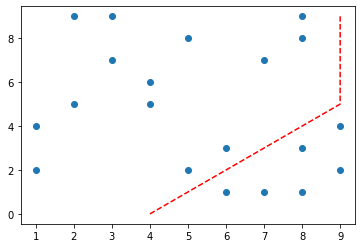

In [13]:
plt.scatter(*zip(*machine.world.obstacle_list)) 
print(machine.vehicle.path)
plt.plot(*zip(*machine.vehicle.path), linestyle = 'dashed', color = 'r') 

In [ ]:
fig, ax = plt.subplots()
ax.bar(machine.states, machine.tpm()[1], width = 0.1)
